In [1]:
import numpy as np
import pandas as pd

from pyNBA.Data.data import QueryData
from pyNBA.Models.ownership import OwnershipModel
from pyNBA.Models.variance import VarianceModel
from pyNBA.Models.constants import OWNERSHIP_PRIMARY_COLS, VARIANCE_PRIMARY_COLS
from pyNBA.DFS.constants import Site
from pyNBA.Backtest.data import GetData
from pyNBA.Backtest.contests import slate_contests_to_enter, get_prizes
from pyNBA.Backtest.lineups import GetLineups

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
max_slate_value = 300
max_contest_value = 100
min_contest_fee = 0.10
max_contest_fee = 5
min_contest_total_entries = 100
max_contest_entries = 20

In [3]:
backtest_data = GetData(Site.DRAFTKINGS)
all_contest_data = backtest_data.get_contest_data(max_contest_entries, max_contest_value)
player_data = backtest_data.get_player_data()
all_contest_results = backtest_data.get_contest_results()

get_lineups = GetLineups()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [12]:
train_data

,SEASON,DATE,SLATEID,GAMECOUNT,PLAYER_ID,PLAYER_NAME,TEAM,POS,SALARY,START,SPREAD,TOTAL,OPPRANK_DvP_L20,OPPRANK_D_L20,LINESTARAPP_PROJECTION,ROTOWIRE_PROJECTION,PROJECTION,FINAL,OWNERSHIP,COMMENT
43907,2017-18,2017-10-18,5ae4e8b05689223dfa4d3bd7,2,512.0,Karl-Anthony Towns,MIN,C,9400.0,1.0,1.0,203.5,15.0,8.0,55.98,44.133727,44.133727,42.25,0.586100,
43919,2017-18,2017-10-18,5ae4e8b05689223dfa4d3bd7,2,489.0,Nikola Jokic,DEN,PF/C,9100.0,1.0,2.5,205.0,9.0,1.0,44.38,38.072550,38.072550,31.00,0.253667,
43927,2017-18,2017-10-18,5ae4e8b05689223dfa4d3bd7,2,558.0,Rudy Gobert,UTA,C,8800.0,1.0,-2.5,205.0,26.0,22.0,39.43,42.152678,42.152678,32.50,0.426533,
43901,2017-18,2017-10-18,5ae4e8b05689223dfa4d3bd7,2,102.0,Jimmy Butler,MIN,SG,8100.0,1.0,1.0,203.5,17.0,8.0,43.03,36.366373,36.366373,23.00,0.530100,
43911,2017-18,2017-10-18,5ae4e8b05689223dfa4d3bd7,2,438.0,LaMarcus Aldridge,SAS,PF/C,7300.0,1.0,-1.0,203.5,15.0,23.0,30.29,NaN,30.290000,48.00,0.488433,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107658,2018-19,2019-04-10,5cafc9dbc31adb60a66063d5,11,777.0,Troy Williams,SAC,SF/PF,3000.0,0.0,3.5,227.0,6.0,11.0,0.00,NaN,0.000000,6.50,0.000350,
107659,2018-19,2019-04-10,5cafc9dbc31adb60a66063d5,11,847.0,Tyler Cavanaugh,UTA,PF,3000.0,0.0,8.0,225.0,26.0,22.0,0.00,NaN,0.000000,5.25,0.001162,
107664,2018-19,2019-04-10,5cafc9dbc31adb60a66063d5,11,871.0,Tyrone Wallace,LAC,PG/SG,3000.0,0.0,-8.0,225.0,3.0,2.0,4.80,NaN,4.800000,8.00,0.000150,
107666,2018-19,2019-04-10,5cafc9dbc31adb60a66063d5,11,222.0,Udonis Haslem,MIA,PF,3000.0,1.0,4.5,219.0,29.0,21.0,1.14,0.000000,1.140000,30.25,0.001658,


In [4]:
results = pd.DataFrame(columns = [
    'DATE', 'GAME_COUNT', 'MAX_ENTRIES', 'TOTAL_ENTRIES',
    'ENTRY_FEE', 'CASHLINE', 'SCORE',
    'TOP_SCORE', 'PRIZE', 'TOP_PRIZE'
])
pnl_1_list = []

for season, season_data in player_data.groupby('SEASON'):

    # get projections
    train_data = player_data.loc[player_data['SEASON'] != season]

    ownership_model = OwnershipModel(train_data, season_data)
    ownership_projections = ownership_model.predict()
    season_data = season_data.merge(ownership_projections, on=OWNERSHIP_PRIMARY_COLS, how='left')

    variance_model = VarianceModel(train_data, season_data)
    variance_projections = variance_model.predict()
    season_data = season_data.merge(variance_projections, on=VARIANCE_PRIMARY_COLS, how='left')

    # iterate through each slate
    season_contest_data = all_contest_data.loc[all_contest_data['DATE'].isin(set(season_data['DATE'].unique()))]
    for (date, slate_id), slate_data in season_contest_data.groupby(['DATE', 'SLATEID']):
        print(pd.to_datetime('now'), date, int(np.sum(pnl_1_list)))

        slate_players = season_data.loc[season_data['SLATEID'] == slate_id]
        if slate_players.empty:
            continue
        
        valid_contests = slate_contests_to_enter(
            slate_data, max_slate_value, max_contest_value, min_contest_fee,
            max_contest_fee, min_contest_total_entries
        )
        slate_data = slate_data.loc[slate_data['CONTESTID'].isin(valid_contests)]
        if slate_data.empty:
            continue
        slate_data = slate_data.sort_values(by='ENTRYFEE', ascending=False)
        total_entries = slate_data['MAXENTRIES'].sum()

        lineups = get_lineups.get_best_lineups_v2(slate_players, total_entries)
        entered_idx = 0

        # iterate through each contest
        for _, contest_data in slate_data.iterrows():
            contest_results = all_contest_results.loc[all_contest_results['CONTESTID'] == contest_data['CONTESTID']]
            if contest_results.empty:
                continue

            result = {} 
            result['DATE'] = date
            result['GAME_COUNT'] = contest_data['GAMECOUNT']
            result['MAX_ENTRIES'] = contest_data['MAXENTRIES']
            result['TOTAL_ENTRIES'] = contest_data['TOTALENTRIES']
            result['ENTRY_FEE'] = contest_data['ENTRYFEE']
            result['CASHLINE'] = contest_data['CASHLINE']
            result['TOP_PRIZE'] = contest_data['TOPPRIZE']
            result['TOP_SCORE'] = contest_data['TOPSCORE']
            
            max_entries = int(contest_data['MAXENTRIES'])
            top_lineups = lineups.iloc[entered_idx:entered_idx+max_entries]
            top_lineup_prizes = get_prizes(top_lineups, contest_results)
            entered_idx += max_entries
            for _, lineup_prize in top_lineup_prizes.iterrows():
                result['SCORE'] = lineup_prize['REALSCORE']
                result['PRIZE'] = lineup_prize['PRIZE']
                results = results.append(result, ignore_index=True)
                pnl = result['PRIZE'] - result['ENTRY_FEE']
                pnl_1_list.append(pnl)


2021-08-30 23:52:32.559076 2017-10-18 0
2021-08-30 23:52:36.673985 2017-10-18 45
2021-08-30 23:52:37.497572 2017-10-18 -33
2021-08-30 23:52:38.341560 2017-10-19 1
2021-08-30 23:52:41.063871 2017-10-19 174
2021-08-30 23:52:41.478163 2017-10-20 140
2021-08-30 23:52:41.892795 2017-10-20 66
2021-08-30 23:52:44.421939 2017-10-20 11
2021-08-30 23:52:44.820842 2017-10-20 26
2021-08-30 23:52:45.251493 2017-10-21 36
2021-08-30 23:52:49.536128 2017-10-21 -89
2021-08-30 23:52:49.996352 2017-10-22 -5
2021-08-30 23:52:51.261298 2017-10-22 -164
2021-08-30 23:52:53.250471 2017-10-23 -102
2021-08-30 23:52:56.147536 2017-10-23 -207
2021-08-30 23:52:56.950343 2017-10-23 -209
2021-08-30 23:52:57.362089 2017-10-24 -269
2021-08-30 23:53:01.711399 2017-10-24 -537
2021-08-30 23:53:02.614014 2017-10-24 -568
2021-08-30 23:53:03.064838 2017-10-25 -626
2021-08-30 23:53:08.138107 2017-10-25 -776
2021-08-30 23:53:09.006183 2017-10-25 -719
2021-08-30 23:53:11.810355 2017-10-26 -879
2021-08-30 23:53:13.589335 2017-1

2021-08-30 23:58:15.726304 2018-01-05 2934
2021-08-30 23:58:17.207145 2018-01-05 2966
2021-08-30 23:58:20.624416 2018-01-06 3034
2021-08-30 23:58:21.516606 2018-01-06 3022
2021-08-30 23:58:21.940399 2018-01-06 3267
2021-08-30 23:58:24.561601 2018-01-07 3488
2021-08-30 23:58:25.406257 2018-01-07 3498
2021-08-30 23:58:28.790770 2018-01-07 8707
2021-08-30 23:58:29.702767 2018-01-08 8925
2021-08-30 23:58:34.503820 2018-01-08 8699
2021-08-30 23:58:34.508907 2018-01-08 8699
2021-08-30 23:58:36.503303 2018-01-09 8622
2021-08-30 23:58:36.506772 2018-01-09 8622
2021-08-30 23:58:37.345392 2018-01-10 8587
2021-08-30 23:58:38.797974 2018-01-10 8759
2021-08-30 23:58:38.803029 2018-01-10 8759
2021-08-30 23:58:43.579303 2018-01-11 8731
2021-08-30 23:58:47.399303 2018-01-11 8655
2021-08-30 23:58:48.269252 2018-01-11 8614
2021-08-30 23:58:48.715234 2018-01-12 8596
2021-08-30 23:58:50.069594 2018-01-12 8501
2021-08-30 23:58:50.560441 2018-01-12 8535
2021-08-30 23:58:55.381020 2018-01-13 9040
2021-08-30 

2021-08-31 00:04:34.215615 2018-03-28 21952
2021-08-31 00:04:37.885472 2018-03-28 21756
2021-08-31 00:04:38.804454 2018-03-29 21711
2021-08-31 00:04:39.734951 2018-03-29 21823
2021-08-31 00:04:41.499199 2018-03-30 21877
2021-08-31 00:04:45.536194 2018-03-30 22137
2021-08-31 00:04:46.463905 2018-03-30 22415
2021-08-31 00:04:46.469633 2018-03-31 22415
2021-08-31 00:04:47.369203 2018-03-31 22387
2021-08-31 00:04:47.374889 2018-03-31 22387
2021-08-31 00:04:48.467195 2018-04-01 22355
2021-08-31 00:04:49.448798 2018-04-01 22399
2021-08-31 00:04:50.845312 2018-04-01 23461
2021-08-31 00:04:50.851115 2018-04-01 23461
2021-08-31 00:04:51.299149 2018-04-03 23449
2021-08-31 00:04:51.776286 2018-04-03 23448
2021-08-31 00:04:56.740366 2018-04-03 23433
2021-08-31 00:04:56.746312 2018-04-03 23433
2021-08-31 00:04:56.751815 2018-04-04 23433
2021-08-31 00:04:59.345575 2018-04-04 23351
2021-08-31 00:04:59.832264 2018-04-05 23339
2021-08-31 00:04:59.838050 2018-04-05 23339
2021-08-31 00:05:02.879223 2018-

2021-08-31 00:11:26.358155 2018-12-15 35622
2021-08-31 00:11:26.364630 2018-12-15 35622
2021-08-31 00:11:30.133899 2018-12-15 35933
2021-08-31 00:11:30.642474 2018-12-16 35931
2021-08-31 00:11:31.709694 2018-12-16 35929
2021-08-31 00:11:33.435174 2018-12-16 36105
2021-08-31 00:11:33.991479 2018-12-17 36112
2021-08-31 00:11:37.337706 2018-12-17 36124
2021-08-31 00:11:38.351084 2018-12-17 36083
2021-08-31 00:11:38.867262 2018-12-18 36068
2021-08-31 00:11:42.785144 2018-12-18 35880
2021-08-31 00:11:43.320713 2018-12-19 35860
2021-08-31 00:11:50.628129 2018-12-19 35689
2021-08-31 00:11:51.648856 2018-12-19 35713
2021-08-31 00:11:52.788930 2018-12-20 35641
2021-08-31 00:11:55.514844 2018-12-21 35487
2021-08-31 00:12:01.376066 2018-12-21 35333
2021-08-31 00:12:02.538469 2018-12-21 35356
2021-08-31 00:12:03.044384 2018-12-22 35341
2021-08-31 00:12:06.973629 2018-12-22 35153
2021-08-31 00:12:06.980147 2018-12-22 35153
2021-08-31 00:12:07.491341 2018-12-23 35177
2021-08-31 00:12:08.484942 2018-

2021-08-31 00:18:37.099028 2019-03-01 42352
2021-08-31 00:18:37.674825 2019-03-02 42345
2021-08-31 00:18:42.306660 2019-03-02 42405
2021-08-31 00:18:43.534198 2019-03-02 42330
2021-08-31 00:18:44.189507 2019-03-03 42479
2021-08-31 00:18:47.996550 2019-03-03 42727
2021-08-31 00:18:52.192719 2019-03-04 42576
2021-08-31 00:18:59.423216 2019-03-04 42386
2021-08-31 00:19:00.005453 2019-03-04 42366
2021-08-31 00:19:01.125680 2019-03-05 42388
2021-08-31 00:19:07.112266 2019-03-05 42439
2021-08-31 00:19:08.440661 2019-03-06 42385
2021-08-31 00:19:14.516796 2019-03-06 42174
2021-08-31 00:19:15.705413 2019-03-06 42105
2021-08-31 00:19:16.273214 2019-03-07 42260
2021-08-31 00:19:22.376965 2019-03-08 42162
2021-08-31 00:19:24.226417 2019-03-08 42083
2021-08-31 00:19:30.088346 2019-03-08 41971
2021-08-31 00:19:30.827383 2019-03-09 41955
2021-08-31 00:19:34.842444 2019-03-09 41759
2021-08-31 00:19:35.415583 2019-03-09 41739
2021-08-31 00:19:36.674765 2019-03-10 41690
2021-08-31 00:19:40.829059 2019-

2021-08-31 00:28:08.318112 2019-11-23 46927
2021-08-31 00:28:15.110240 2019-11-23 46795
2021-08-31 00:28:16.481743 2019-11-23 46705
2021-08-31 00:28:16.489244 2019-11-24 46705
2021-08-31 00:28:21.460537 2019-11-24 46616
2021-08-31 00:28:22.114901 2019-11-25 46596
2021-08-31 00:28:30.562151 2019-11-25 46521
2021-08-31 00:28:32.178449 2019-11-25 46421
2021-08-31 00:28:32.185971 2019-11-26 46421
2021-08-31 00:28:40.549250 2019-11-27 46490
2021-08-31 00:28:51.052762 2019-11-27 46272
2021-08-31 00:28:53.100923 2019-11-27 46153
2021-08-31 00:28:53.108366 2019-11-27 46153
2021-08-31 00:28:53.115500 2019-11-29 46153
2021-08-31 00:29:02.107265 2019-11-29 45933
2021-08-31 00:29:03.464751 2019-11-29 45914
2021-08-31 00:29:04.117100 2019-11-29 45937
2021-08-31 00:29:04.124778 2019-11-30 45937
2021-08-31 00:29:09.758304 2019-11-30 45745
2021-08-31 00:29:11.119954 2019-12-01 45682
2021-08-31 00:29:15.127866 2019-12-01 45522
2021-08-31 00:29:17.436585 2019-12-01 45423
2021-08-31 00:29:18.079102 2019-

2021-08-31 00:38:42.520898 2020-02-03 66842
2021-08-31 00:38:44.545337 2020-02-03 66815
2021-08-31 00:38:46.123068 2020-02-04 66753
2021-08-31 00:38:51.535435 2020-02-04 66528
2021-08-31 00:38:52.899398 2020-02-05 66546
2021-08-31 00:38:58.511130 2020-02-05 66373
2021-08-31 00:38:59.850854 2020-02-05 66371
2021-08-31 00:39:00.638918 2020-02-05 66356
2021-08-31 00:39:00.647202 2020-02-06 66356
2021-08-31 00:39:08.064795 2020-02-06 66187
2021-08-31 00:39:08.755035 2020-02-06 66167
2021-08-31 00:39:10.124081 2020-02-07 66226
2021-08-31 00:39:16.890720 2020-02-07 66072
2021-08-31 00:39:18.202946 2020-02-07 65977
2021-08-31 00:39:18.869678 2020-02-08 65971
2021-08-31 00:39:26.434926 2020-02-08 65752
2021-08-31 00:39:27.806190 2020-02-08 65801
2021-08-31 00:39:27.814552 2020-02-08 65801
2021-08-31 00:39:27.822551 2020-02-09 65801
2021-08-31 00:39:36.010634 2020-02-09 65565
2021-08-31 00:39:37.388769 2020-02-10 65468
2021-08-31 00:39:46.054546 2020-02-10 65212
2021-08-31 00:39:47.503046 2020-

In [5]:
player_data.loc[player_data['DATE'] == '2018-11-14']

,SEASON,DATE,SLATEID,GAMECOUNT,PLAYER_ID,PLAYER_NAME,TEAM,POS,SALARY,START,SPREAD,TOTAL,OPPRANK_DvP_L20,OPPRANK_D_L20,LINESTARAPP_PROJECTION,ROTOWIRE_PROJECTION,PROJECTION,FINAL,OWNERSHIP,COMMENT
63482,2018-19,2018-11-14,5bed467477def747b2adf008,3,387.0,Anthony Davis,NOP,PF/C,11300.0,1.0,-1.5,234.0,19.0,25.0,55.63,53.858697,53.858697,60.25,0.396567,
63505,2018-19,2018-11-14,5bed467477def747b2adf008,3,178.0,Giannis Antetokounmpo,MIL,SF/PF,11000.0,1.0,-9.5,212.5,2.0,9.0,51.26,52.625625,52.625625,51.25,0.232567,
63540,2018-19,2018-11-14,5bed467477def747b2adf008,3,166.0,Paul George,OKC,SF/PF,9600.0,1.0,-8.5,213.0,19.0,20.0,49.43,42.739712,42.739712,59.75,0.244033,
63520,2018-19,2018-11-14,5bed467477def747b2adf008,3,512.0,Karl-Anthony Towns,MIN,C,9500.0,1.0,1.5,234.0,23.0,28.0,55.71,47.908218,47.908218,53.50,0.292600,
63518,2018-19,2018-11-14,5bed467477def747b2adf008,3,393.0,Jrue Holiday,NOP,PG/SG,8500.0,1.0,-1.5,234.0,9.0,25.0,43.11,37.766298,37.766298,36.50,0.315267,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54043,2018-19,2018-11-14,5b45e92562fa9e4e0fe815d7,11,274.0,Troy Daniels,PHX,SG,3000.0,0.0,6.0,213.0,10.0,11.0,3.10,NaN,3.100000,0.00,0.000067,DNP - Coach's Decision
54049,2018-19,2018-11-14,5b45e92562fa9e4e0fe815d7,11,222.0,Udonis Haslem,MIA,PF,3000.0,0.0,-2.0,214.0,6.0,15.0,0.00,NaN,0.000000,2.00,0.000000,
54050,2018-19,2018-11-14,5b45e92562fa9e4e0fe815d7,11,774.0,Wade Baldwin IV,POR,PG,3000.0,0.0,2.5,222.5,5.0,23.0,0.00,NaN,0.000000,0.00,0.000075,DNP - Coach's Decision
54052,2018-19,2018-11-14,5b45e92562fa9e4e0fe815d7,11,776.0,Wayne Selden,MEM,SG,3000.0,0.0,9.5,212.5,24.0,10.0,9.91,NaN,9.910000,14.50,0.001125,


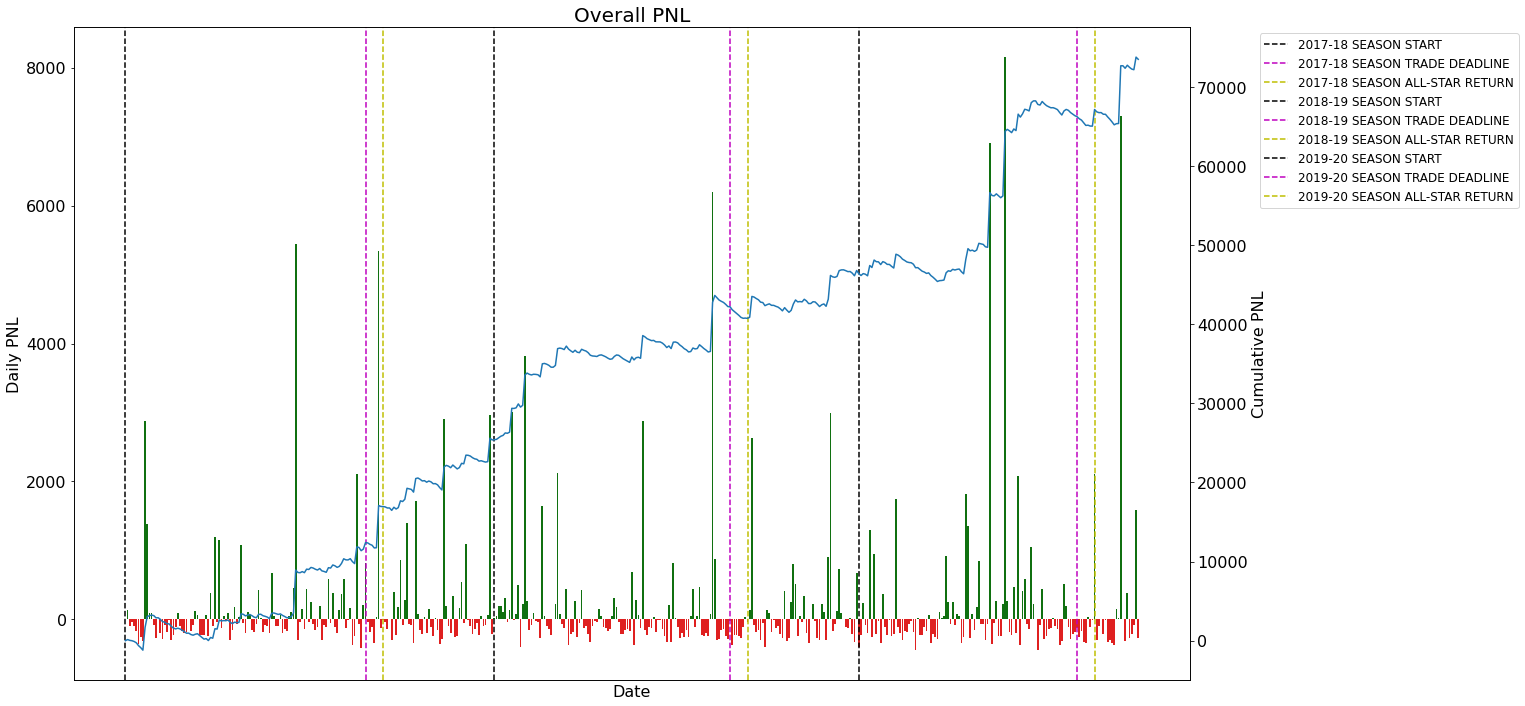

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(1, figsize=(20, 12))

# overall PNL
temp = results.copy()
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl = pnl.loc[pnl['PRIZE'] < 50000]
pnl['RUNNING_PNL'] = pnl['PNL'].cumsum()

pnl['COLOR'] = pnl['PNL'].apply(lambda x: 'green' if x > 0 else 'red')
ax1 = sns.barplot(x=pnl.index, y='PNL', data=pnl, palette=pnl['COLOR'])
ax1.set_title('Overall PNL', fontsize=20)

xcoords = {
    pnl.index.min(): ('2017-18 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2018-02-08'][0]: ('2017-18 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2018-02-22'][0]: ('2017-18 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2018-10-19'][0]: ('2018-19 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2019-02-07'][0]: ('2018-19 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2019-02-21'][0]: ('2018-19 SEASON ALL-STAR RETURN', 'y'),
    pnl.index[pnl['DATE'] == '2019-10-25'][0]: ('2019-20 SEASON START', 'k'),
    pnl.index[pnl['DATE'] == '2020-02-06'][0]: ('2019-20 SEASON TRADE DEADLINE', 'm'),
    pnl.index[pnl['DATE'] == '2020-02-20'][0]: ('2019-20 SEASON ALL-STAR RETURN', 'y'),
    
}
for xcoord in xcoords:
    ax1.axvline(x=xcoord, label=xcoords[xcoord][0], color=xcoords[xcoord][1], linestyle='dashed')
ax1.legend(bbox_to_anchor=(1.3, 1), loc='upper right', prop={'size': 12})

ax2 = ax1.twinx()
sns.lineplot(x=pnl.index, y='RUNNING_PNL', data=pnl, sort=False, color='tab:blue', ax=ax2)

ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Daily PNL', fontsize=16)
ax2.set_ylabel('Cumulative PNL', fontsize=16)
ax1.set_xticks([])

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

plt.show()

Break down ROI by contest type, entry fee, and number of games in the slate to determine where my projections generate the most return on investment.


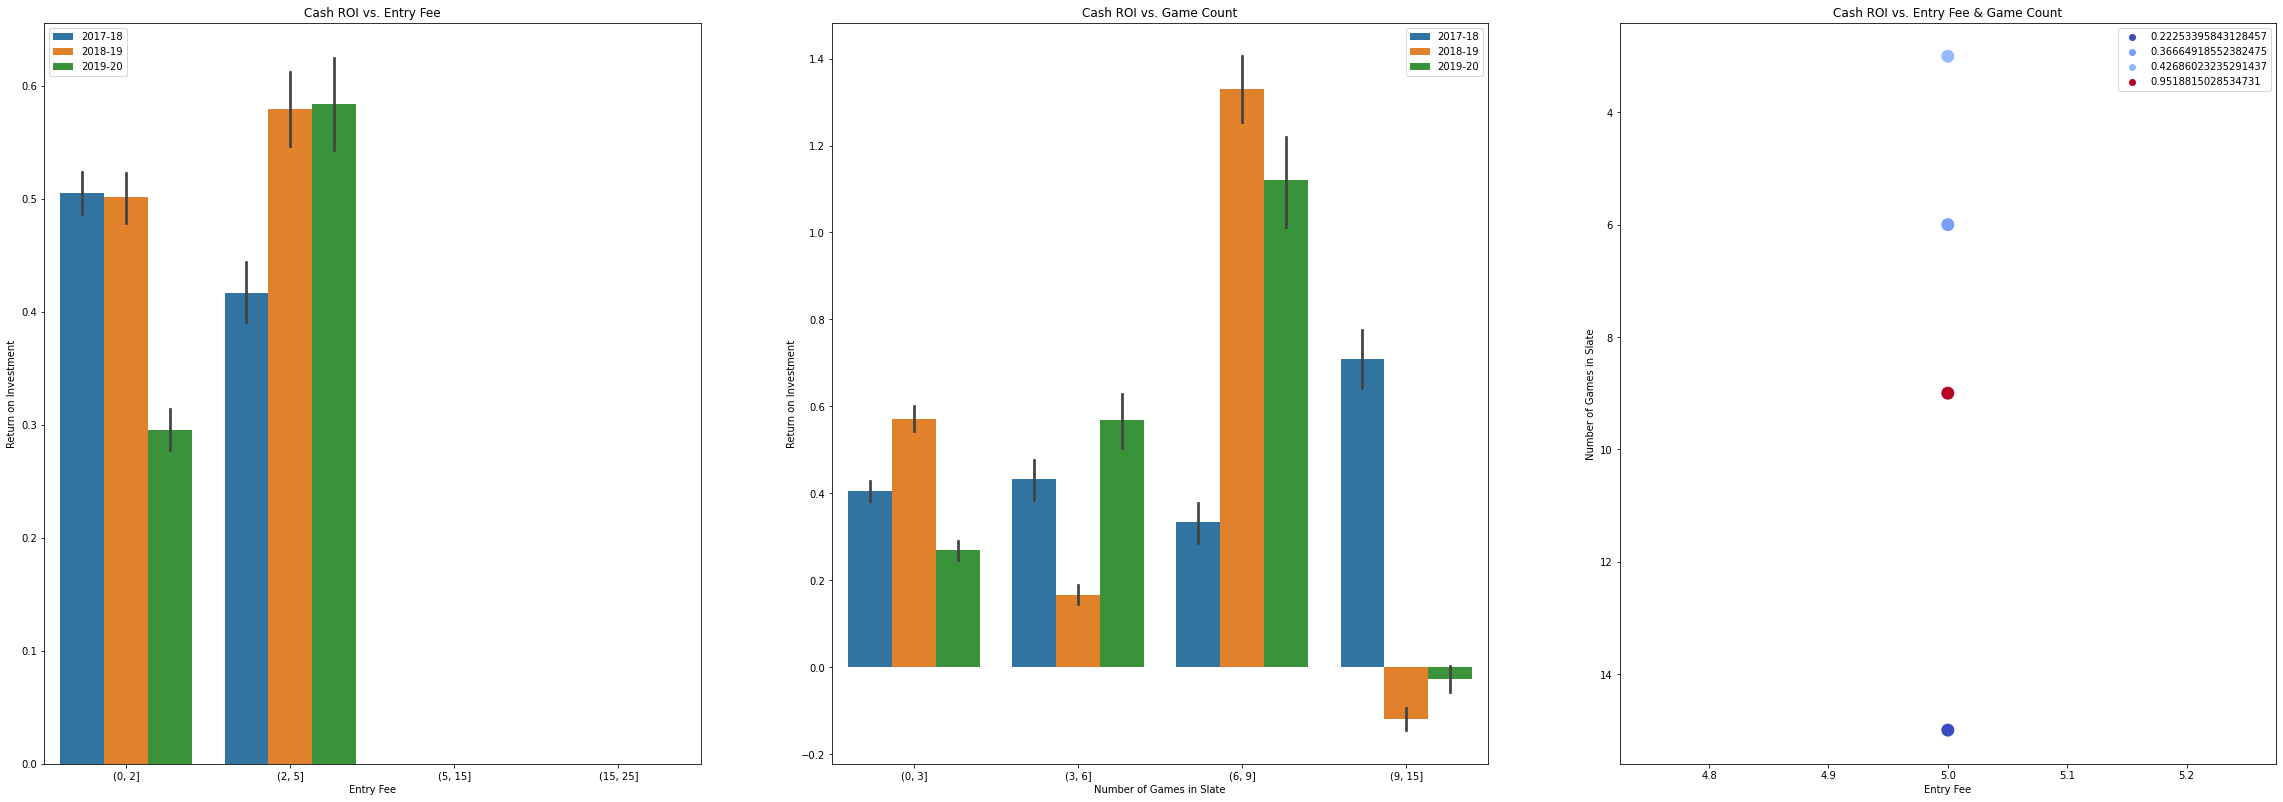

In [7]:
fig = plt.figure(1, figsize=(40, 30))
gs = fig.add_gridspec(2, 3)

# ROI vs. Entry Fee
temp = results.copy()
temp['ENTRY_BIN'] = pd.cut(temp['ENTRY_FEE'], bins=[0, 2, 5, 15, 25], duplicates='drop')
pnl = temp.groupby(['DATE', 'ENTRY_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(player_data[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax4 = fig.add_subplot(gs[1, 0])
sns.barplot(x="ENTRY_BIN", y="ROI", hue="SEASON", data=pnl, ax=ax4)
ax4.set(xlabel="Entry Fee", ylabel="Return on Investment", title="Cash ROI vs. Entry Fee")
ax4.legend()

# ROI vs. Game Count
temp = results.copy()
temp['GAME_BIN'] = pd.cut(temp['GAME_COUNT'], bins=[0, 3, 6, 9, 15], duplicates='drop')
pnl = temp.groupby(['DATE', 'GAME_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(player_data[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax5 = fig.add_subplot(gs[1, 1])
sns.barplot(x="GAME_BIN", y="ROI", hue="SEASON", data=pnl, ax=ax5)
ax5.set(xlabel="Number of Games in Slate", ylabel="Return on Investment", title="Cash ROI vs. Game Count")
ax5.legend()

# ROI vs. Entry Fee & Game Count
temp = results.copy()
temp['ENTRY_BIN'] = pd.cut(temp['ENTRY_FEE'], bins=[0, 5, 10, 25, 50, 100, 250], duplicates='drop')
temp['GAME_BIN'] = pd.cut(temp['GAME_COUNT'], bins=[0, 3, 6, 9, 15], duplicates='drop')
pnl = temp.groupby(['DATE', 'ENTRY_BIN', 'GAME_BIN']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum()
    })
).reset_index()
pnl = pnl.merge(player_data[['DATE', 'SEASON']], on=['DATE'], how='left')
pnl['ROI'] = (pnl['PRIZE'] - pnl['ENTRY_FEE'])/pnl['ENTRY_FEE']

ax6 = fig.add_subplot(gs[1, 2])
pnl['UPPER_ENTRY_FEE'] = pnl['ENTRY_BIN'].apply(lambda x: x.right)
pnl['UPPER_GAME_BIN'] = pnl['GAME_BIN'].apply(lambda x: x.right)
scat = pnl.groupby(['UPPER_GAME_BIN', 'UPPER_ENTRY_FEE']).apply(
    lambda x: pd.Series({
        'ROI': x['ROI'].mean()
    })
).reset_index()
sns.scatterplot(x='UPPER_ENTRY_FEE', y="UPPER_GAME_BIN", data=scat, hue='ROI', s=200, palette='coolwarm', ax=ax6)
ax6.set(xlabel="Entry Fee", ylabel="Number of Games in Slate", title="Cash ROI vs. Entry Fee & Game Count")
ax6.legend()

plt.show()

It is important not to overfit by cherry picking the contests in which the projections made money. To try to avoid this, I bucketed the entry fees and slate game counts. I will also only isolate a subset of contests if it makes sense why they were more profitable. The results above show that virtually no subset of cash games are profitable. On the other hand, tournaments whose entry fees are at most $1000 and slate game counts are at most 6 look profitable. This makes sense: higher entry contests attract more intelligent players, and high game slates introduce more variance.

Below I will graph the cumulative PNL of a strategy that only enters contests in the subset described above. I will also include cash games whose entry fees are at most $25 and slate game counts are at most 3 to verify the lack of edge.

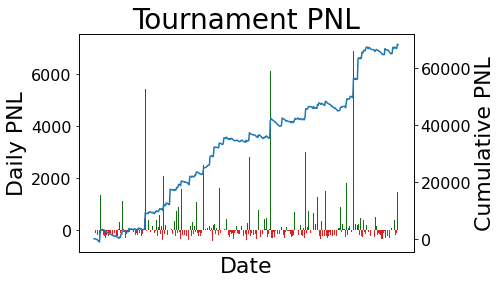

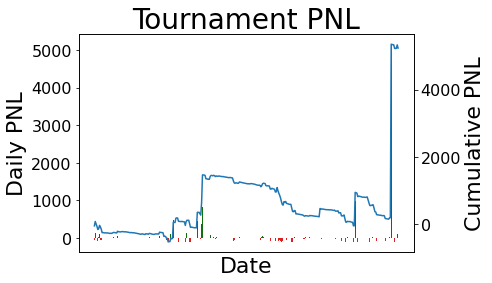

In [19]:
# fig, plt.figure(1, figsize=(30, 15))

temp = results.loc[(results['ENTRY_FEE'] <= 4)]
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['RUNNING_PNL'] = pnl['PNL'].cumsum()

pnl['COLOR'] = pnl['PNL'].apply(lambda x: 'green' if x > 0 else 'red')
ax1 = sns.barplot(x=pnl.index, y='PNL', data=pnl, palette=pnl['COLOR'])
ax1.set_title('Tournament PNL', fontsize=28)

ax2 = ax1.twinx()
sns.lineplot(x=pnl.index, y='RUNNING_PNL', data=pnl, sort=False, color='tab:blue', ax=ax2)

ax1.set_xlabel('Date', fontsize=22)
ax1.set_ylabel('Daily PNL', fontsize=22)
ax2.set_ylabel('Cumulative PNL', fontsize=22)
ax1.set_xticks([])

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

plt.show()

temp = results.loc[(results['ENTRY_FEE'] == 5)]
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['RUNNING_PNL'] = pnl['PNL'].cumsum()

pnl['COLOR'] = pnl['PNL'].apply(lambda x: 'green' if x > 0 else 'red')
ax1 = sns.barplot(x=pnl.index, y='PNL', data=pnl, palette=pnl['COLOR'])
ax1.set_title('Tournament PNL', fontsize=28)

ax2 = ax1.twinx()
sns.lineplot(x=pnl.index, y='RUNNING_PNL', data=pnl, sort=False, color='tab:blue', ax=ax2)

ax1.set_xlabel('Date', fontsize=22)
ax1.set_ylabel('Daily PNL', fontsize=22)
ax2.set_ylabel('Cumulative PNL', fontsize=22)
ax1.set_xticks([])

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

plt.show()

In [9]:
print(len(pnl.loc[pnl['COLOR'] == 'red']))
print(len(pnl.loc[pnl['COLOR'] == 'green']))

287
178


In [10]:
results.loc[results['DATE'] == '2018-02-14'].sort_values(by='PRIZE')

,DATE,GAME_COUNT,MAX_ENTRIES,TOTAL_ENTRIES,ENTRY_FEE,CASHLINE,SCORE,TOP_SCORE,PRIZE,TOP_PRIZE
17737,2018-02-14,12,20.0,27781,2.14,291.00,280.00,365.75,0.0,2000.0
17797,2018-02-14,12,20.0,47562,0.25,283.75,283.50,366.25,0.0,400.0
17730,2018-02-14,12,20.0,27781,2.14,291.00,272.75,365.75,0.0,2000.0
17830,2018-02-14,2,20.0,17835,1.00,292.50,275.25,354.75,0.0,750.0
17760,2018-02-14,12,20.0,7134,1.00,289.25,268.75,370.25,0.0,500.0
...,...,...,...,...,...,...,...,...,...,...
17699,2018-02-14,12,3.0,1981,3.00,293.00,358.25,354.75,500.0,500.0
17706,2018-02-14,12,20.0,1981,3.00,293.75,372.00,360.50,500.0,500.0
17777,2018-02-14,12,20.0,7134,1.00,289.25,376.25,370.25,500.0,500.0
17728,2018-02-14,12,20.0,27781,2.14,291.00,362.00,365.75,750.0,2000.0


I will only focus on tournament contests going forward. The tournament strategy seems like it may actually be profitable. However, there is a lot of variance in PNL, as the cumulative PNL depends entirely on a few days in which it hit big. Most days the strategy loses money, and there are some significant drawdowns.

Below shows the distribution of daily returns of this strategy.

In [11]:
temp = results.loc[(results['ENTRY_FEE'] < 2) & (results['LINEUP_TYPE'] == 1)]
temp['PNL'] = temp['PRIZE'] - temp['ENTRY_FEE']
pnl = temp.groupby(['DATE']).apply(
    lambda x: pd.Series({
        'ENTRY_FEE': x['ENTRY_FEE'].sum(),
        'PRIZE': x['PRIZE'].sum(),
        'PNL': x['PNL'].sum()
    })
).reset_index()
pnl['ROI'] = pnl['PNL']/pnl['ENTRY_FEE']
ax = sns.distplot(pnl['ROI'])
ax.set_title('PNL Distribution', fontsize=18)
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

print('ROI Statistics:')
pnl['PNL'].describe()

KeyError: 'LINEUP_TYPE'

In [ ]:
print(pnl['PNL'].mean())
print(pnl['PNL'].std())
print(pnl['ENTRY_FEE'].mean())

In [ ]:
from pyNBA.Data.data import QueryData
query_data = QueryData()
boxscores = query_data.query_boxscore_data()

In [ ]:
display(boxscores)

In [ ]:
from nba_api.stats.endpoints import BoxScoreAdvancedV2
box = BoxScoreAdvancedV2(game_id='0021900969').get_data_frames()[0]
nyk = box.loc[box['TEAM_ID'] == 1610612737]

In [ ]:
print(nyk['USG_PCT'].sum())

In [ ]:
display(nyk)

In [21]:
from random import random
random.choice([0, 1])

AttributeError: 'builtin_function_or_method' object has no attribute 'choice'